In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Mounted at /content/drive


# TRX

In [3]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/TRX-USD.csv',usecols=['Date','Close'],index_col='Date',parse_dates=True)

<Axes: xlabel='Date'>

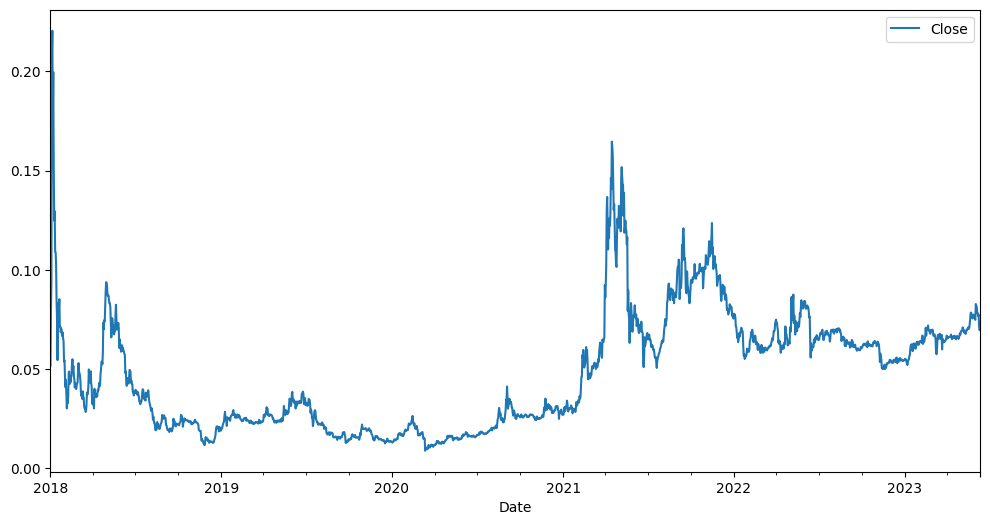

In [4]:
df.plot(figsize=(12,6))

In [7]:
df1 = df.reset_index()['Close']

In [8]:
len(df1)

1989

## 7:2:1

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [11]:
test_size

397

In [12]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

em đã thử huấn luyện mô hình với time_step = 100 thế nhưng các chỉ số MAPE, MAE, RMSE quá cao. Do đó em tiến hành thử nghiệm vời time_step lần lượt tăng 10 giá trị

In [13]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [15]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 39ms/step - loss: 0.0039 - val_loss: 9.7529e-04
Epoch 2/100
21/21 [==============================] - 1s 25ms/step - loss: 0.0010 - val_loss: 8.7323e-04
Epoch 3/100
21/21 [==============================] - 1s 24ms/step - loss: 8.2626e-04 - val_loss: 3.6244e-04
Epoch 4/100
21/21 [==============================] - 0s 23ms/step - loss: 6.8856e-04 - val_loss: 4.0047e-04
Epoch 5/100
21/21 [==============================] - 1s 24ms/step - loss: 6.0537e-04 - val_loss: 5.5186e-04
Epoch 6/100
21/21 [==============================] - 0s 23ms/step - loss: 5.6231e-04 - val_loss: 3.9230e-04
Epoch 7/100
21/21 [==============================] - 1s 39ms/step - loss: 5.2454e-04 - val_loss: 2.6502e-04
Epoch 8/100
21/21 [==============================] - 1s 42ms/step - loss: 4.9876e-04 - val_loss: 2.9159e-04
Epoch 9/100
21/21 [==============================] - 1s 43ms/step - loss: 4.7675e-04 - val_loss: 3.2332e-04
Epoch 10/100
21/21 [================

In [18]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 12ms/step


In [19]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [20]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs( (yval - y_pred_val) / yval )) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 75.47360995800848
MAE: 0.21427085549493904
RMSE: 0.21566474189936502
--------------------------
---------TEST----------
MAPE: 75.07661093109928
MAE: 0.20183809341519848
RMSE: 0.20458224507466036
-------------------


In [21]:
y_pred.shape

(296, 1)

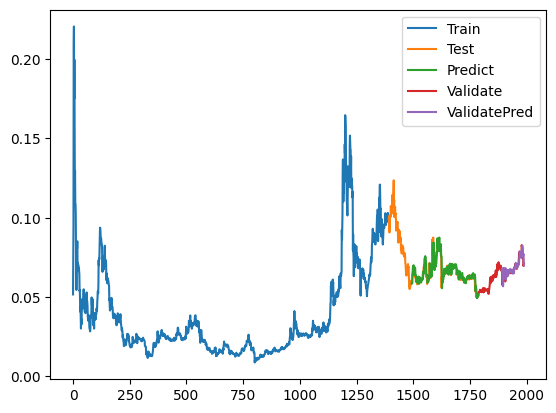

In [22]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [23]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [24]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [25]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [26]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(100, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [28]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 80ms/step - loss: 0.0137 - val_loss: 0.0301
Epoch 2/100
14/14 [==============================] - 1s 66ms/step - loss: 0.0013 - val_loss: 0.0105
Epoch 3/100
14/14 [==============================] - 1s 64ms/step - loss: 6.4353e-04 - val_loss: 0.0044
Epoch 4/100
14/14 [==============================] - 1s 67ms/step - loss: 4.2395e-04 - val_loss: 0.0027
Epoch 5/100
14/14 [==============================] - 1s 65ms/step - loss: 3.6236e-04 - val_loss: 0.0031
Epoch 6/100
14/14 [==============================] - 1s 56ms/step - loss: 3.1886e-04 - val_loss: 0.0035
Epoch 7/100
14/14 [==============================] - 1s 40ms/step - loss: 2.9851e-04 - val_loss: 0.0032
Epoch 8/100
14/14 [==============================] - 1s 39ms/step - loss: 2.7373e-04 - val_loss: 0.0026
Epoch 9/100
14/14 [==============================] - 1s 39ms/step - loss: 2.7218e-04 - val_loss: 0.0023
Epoch 10/100
14/14 [==============================] - 1s 40ms/step - los

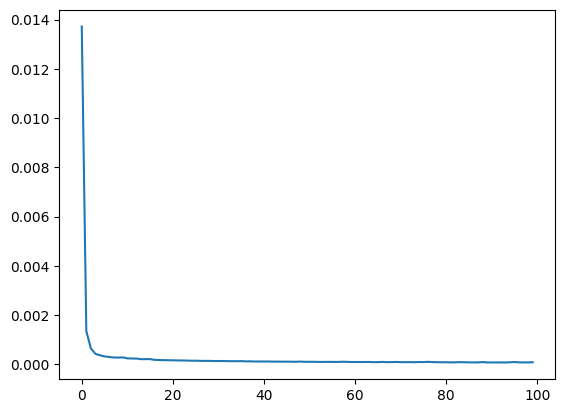

In [29]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [30]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 7ms/step


In [31]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

In [32]:
test_data.shape

(397, 1)

In [33]:
y_pred1.shape

(495, 1)

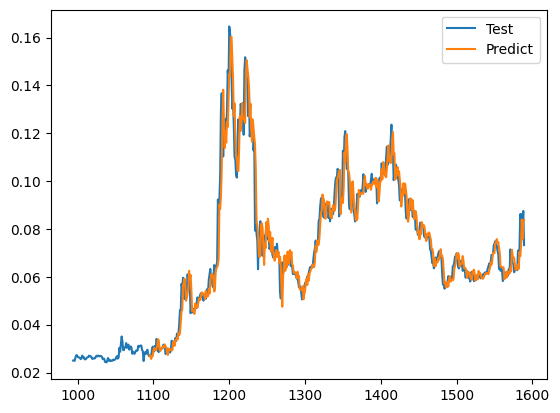

In [34]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [35]:
val_data1.shape

(399, 1)

In [36]:
y_pred_val1.shape

(298, 1)

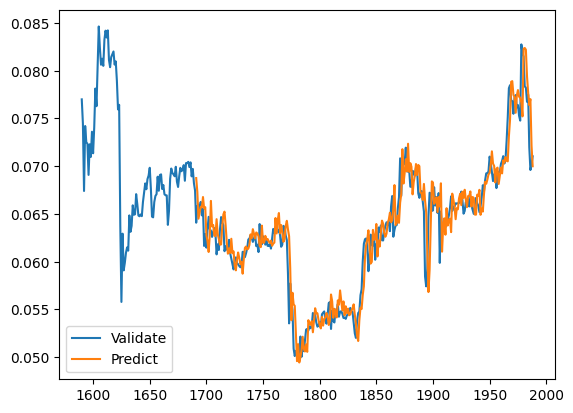

In [37]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [38]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 74.91946320281028
MAE: 0.19298959184029807
RMSE: 0.19555768124672904
--------------------------
---------TEST----------
MAPE: 71.62474365804009
MAE: 0.24248613847996475
RMSE: 0.2734733586932138
-------------------


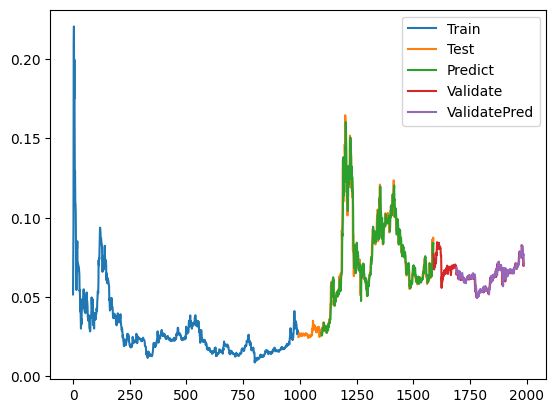

In [39]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# DOGE

In [40]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv',usecols=['Date','Close'],index_col='Date',parse_dates=True)

In [41]:
df.head()

,Close
Date,
2018-01-01,0.008909
2018-01-02,0.009145
2018-01-03,0.009320
2018-01-04,0.009644
2018-01-05,0.012167


<Axes: xlabel='Date'>

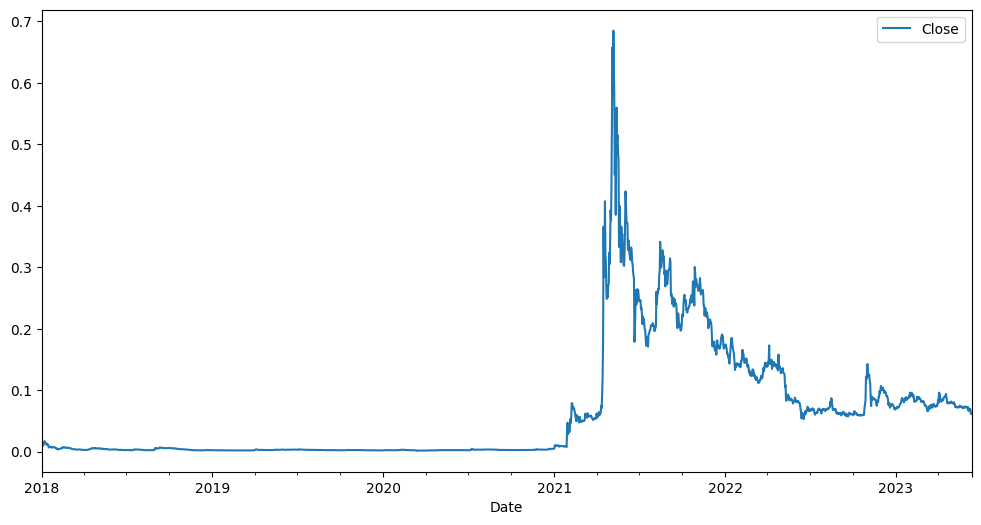

In [42]:
df.plot(figsize=(12,6))

In [43]:
df1 = df.reset_index()['Close']

In [44]:
len(df1)

1989

## 7:2:1

In [45]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [46]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [47]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [48]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [49]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [50]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(100, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 44ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 2/100
21/21 [==============================] - 1s 34ms/step - loss: 8.1344e-04 - val_loss: 3.5522e-04
Epoch 3/100
21/21 [==============================] - 1s 32ms/step - loss: 6.3413e-04 - val_loss: 0.0010
Epoch 4/100
21/21 [==============================] - 1s 35ms/step - loss: 5.6606e-04 - val_loss: 2.5956e-04
Epoch 5/100
21/21 [==============================] - 1s 33ms/step - loss: 4.7872e-04 - val_loss: 1.6071e-04
Epoch 6/100
21/21 [==============================] - 1s 35ms/step - loss: 4.4173e-04 - val_loss: 3.1025e-04
Epoch 7/100
21/21 [==============================] - 1s 34ms/step - loss: 4.7327e-04 - val_loss: 2.1690e-04
Epoch 8/100
21/21 [==============================] - 1s 33ms/step - loss: 4.1703e-04 - val_loss: 1.7171e-04
Epoch 9/100
21/21 [==============================] - 1s 51ms/step - loss: 4.5362e-04 - val_loss: 2.8584e-04
Epoch 10/100
21/21 [====================

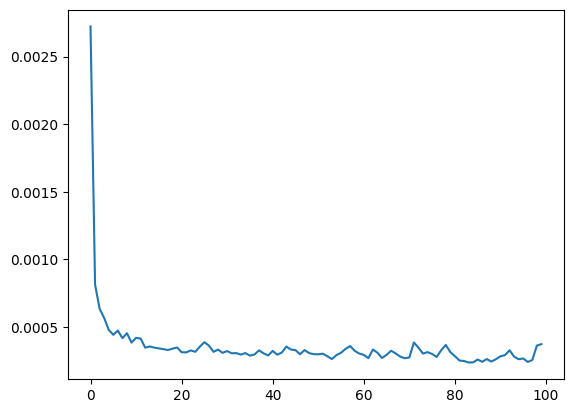

In [53]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [54]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 17ms/step


In [55]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

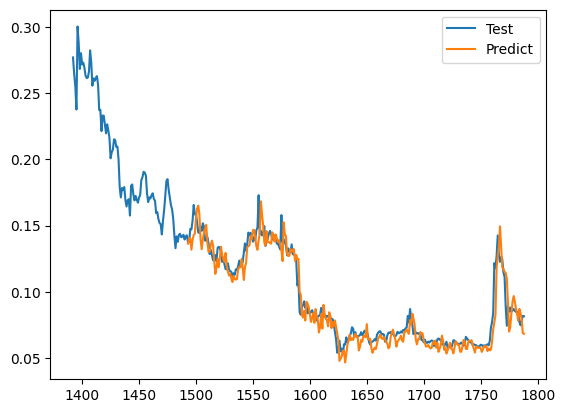

In [56]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

In [57]:
print(val_data.shape)
print(y_pred_val.shape)

(200, 1)
(99, 1)


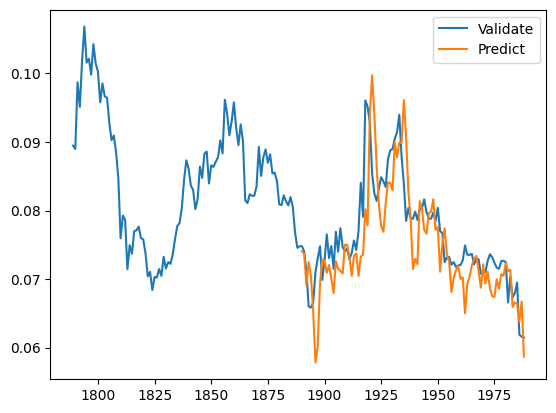

In [58]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [59]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 31.53703699807389
MAE: 0.03515263644552579
RMSE: 0.037362926114054465
--------------------------
---------TEST----------
MAPE: 40.4598040971352
MAE: 0.05882175745572822
RMSE: 0.07300384260262582
-------------------


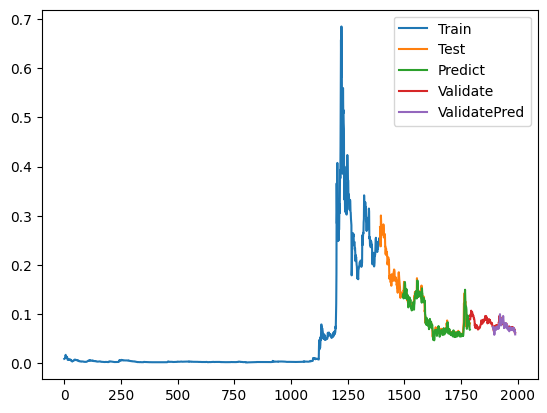

In [60]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [61]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [62]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [63]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [64]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(100, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [65]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [66]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 56ms/step - loss: 0.0012 - val_loss: 0.1154
Epoch 2/100
14/14 [==============================] - 1s 41ms/step - loss: 1.7461e-05 - val_loss: 0.1130
Epoch 3/100
14/14 [==============================] - 1s 41ms/step - loss: 5.7300e-06 - val_loss: 0.1092
Epoch 4/100
14/14 [==============================] - 1s 39ms/step - loss: 3.0934e-06 - val_loss: 0.1052
Epoch 5/100
14/14 [==============================] - 1s 40ms/step - loss: 2.7113e-06 - val_loss: 0.1014
Epoch 6/100
14/14 [==============================] - 1s 41ms/step - loss: 2.5549e-06 - val_loss: 0.0976
Epoch 7/100
14/14 [==============================] - 1s 41ms/step - loss: 2.4573e-06 - val_loss: 0.0940
Epoch 8/100
14/14 [==============================] - 1s 40ms/step - loss: 2.4021e-06 - val_loss: 0.0905
Epoch 9/100
14/14 [==============================] - 1s 40ms/step - loss: 2.3524e-06 - val_loss: 0.0874
Epoch 10/100
14/14 [==============================] - 1s 40ms/step -

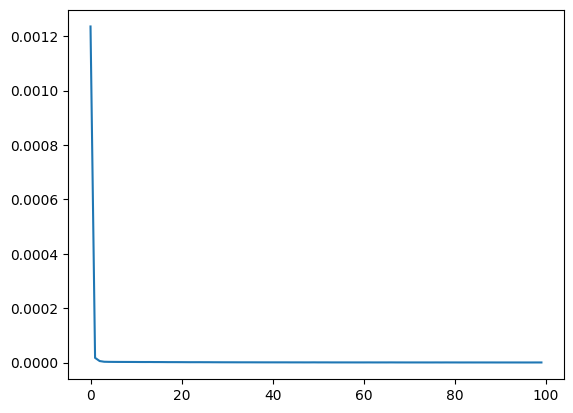

In [67]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [68]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 10ms/step


In [69]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

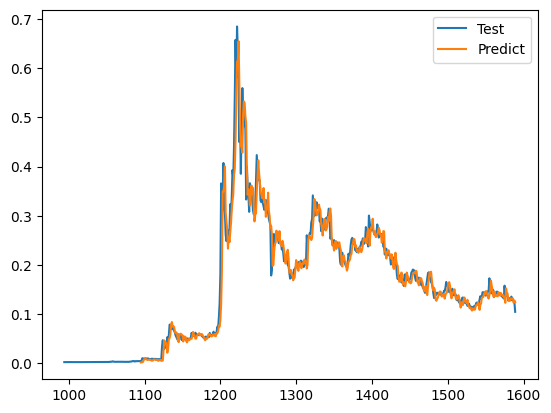

In [70]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [71]:
print(val_data1.shape)
print(y_pred_val1.shape)

(399, 1)
(298, 1)


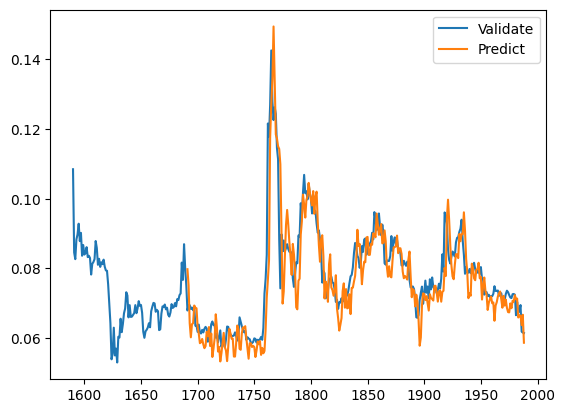

In [72]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [73]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 31.52433727290524
MAE: 0.037224723573239776
RMSE: 0.04372100414181993
--------------------------
---------TEST----------
MAPE: 169.2382903928782
MAE: 0.16860654658351562
RMSE: 0.2177773435766513
-------------------


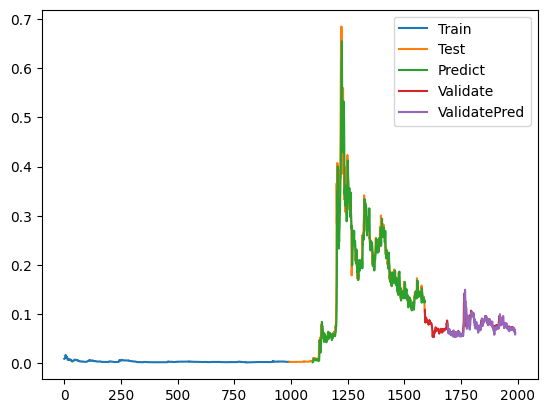

In [74]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# XRP

In [81]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/XRP-USD.csv',usecols=['Date','Close'],index_col='Date')

In [82]:
df

,Close
Date,
2018-01-01,2.391030
2018-01-02,2.480900
2018-01-03,3.105370
2018-01-04,3.196630
2018-01-05,3.048710
...,...
2023-06-08,0.524546
2023-06-09,0.537917
2023-06-10,0.508199


<Axes: xlabel='Date'>

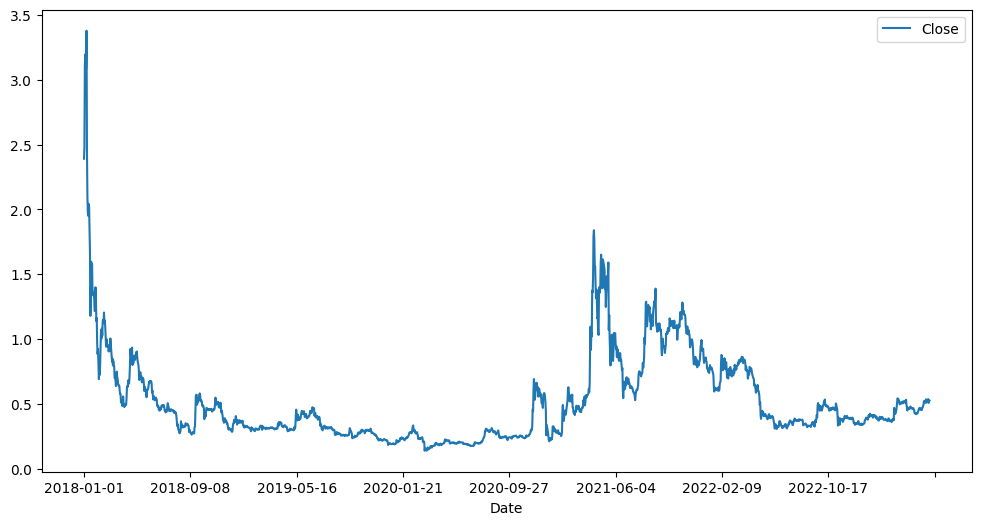

In [83]:
df.plot(figsize=(12,6))

In [84]:
df1 = df.reset_index()['Close']

In [85]:
df1

0       2.391030
1       2.480900
2       3.105370
3       3.196630
4       3.048710
          ...   
1984    0.524546
1985    0.537917
1986    0.508199
1987    0.521221
1988    0.525721
Name: Close, Length: 1989, dtype: float64

In [86]:
len(df1)

1989

## 7:2:1

In [87]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [88]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [89]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [90]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [91]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [92]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(100, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [93]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 45ms/step - loss: 0.0029 - val_loss: 2.8364e-04
Epoch 2/100
21/21 [==============================] - 1s 35ms/step - loss: 6.3001e-04 - val_loss: 2.0627e-04
Epoch 3/100
21/21 [==============================] - 1s 34ms/step - loss: 4.9332e-04 - val_loss: 1.7905e-04
Epoch 4/100
21/21 [==============================] - 1s 34ms/step - loss: 4.2526e-04 - val_loss: 1.6763e-04
Epoch 5/100
21/21 [==============================] - 1s 35ms/step - loss: 4.2950e-04 - val_loss: 2.1576e-04
Epoch 6/100
21/21 [==============================] - 1s 34ms/step - loss: 4.0547e-04 - val_loss: 1.5863e-04
Epoch 7/100
21/21 [==============================] - 1s 38ms/step - loss: 3.8064e-04 - val_loss: 1.4423e-04
Epoch 8/100
21/21 [==============================] - 1s 57ms/step - loss: 3.4088e-04 - val_loss: 1.5116e-04
Epoch 9/100
21/21 [==============================] - 1s 55ms/step - loss: 3.6034e-04 - val_loss: 1.3600e-04
Epoch 10/100
21/21 [============

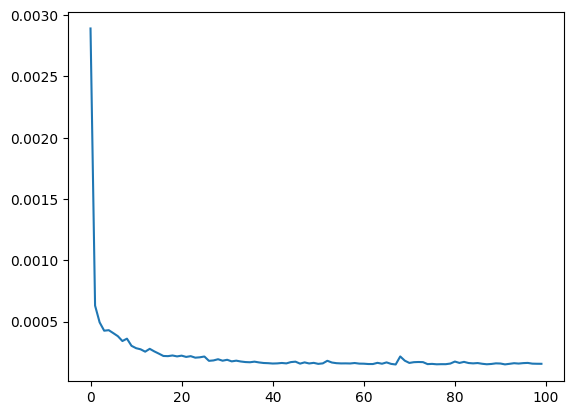

In [95]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [96]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 8ms/step


In [97]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

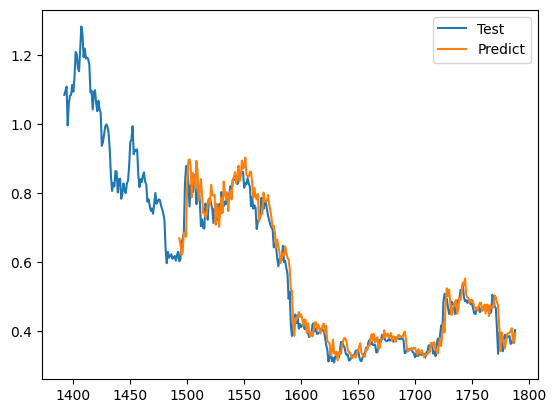

In [98]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

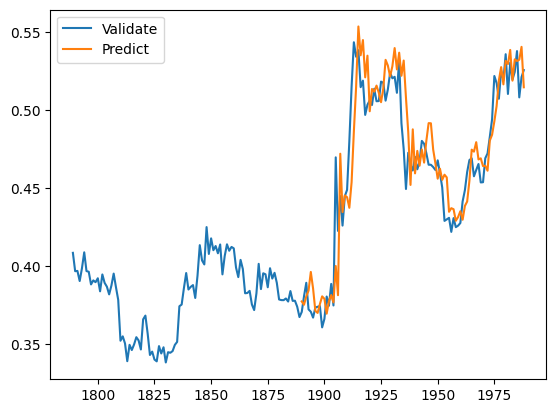

In [99]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [100]:
print(val_data.shape)
print(y_pred_val.shape)

(200, 1)
(99, 1)


In [101]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 380.9844458710267
MAE: 0.3697405266602366
RMSE: 0.37376317475271853
--------------------------
---------TEST----------
MAPE: 464.296295188921
MAE: 0.4067760286450046
RMSE: 0.4503516492049856
-------------------


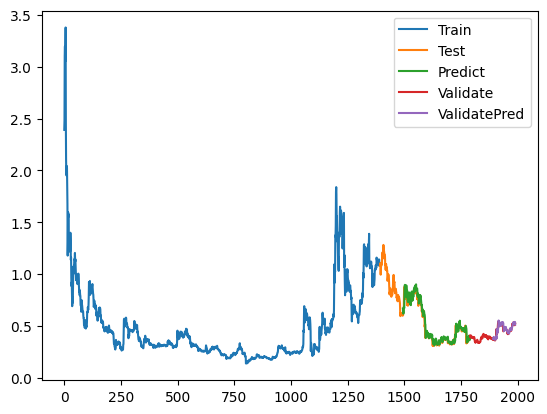

In [102]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [103]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [104]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [105]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [106]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(100, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [107]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [108]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 86ms/step - loss: 0.0090 - val_loss: 0.0185
Epoch 2/100
14/14 [==============================] - 1s 62ms/step - loss: 7.9315e-04 - val_loss: 0.0166
Epoch 3/100
14/14 [==============================] - 1s 63ms/step - loss: 3.9727e-04 - val_loss: 0.0091
Epoch 4/100
14/14 [==============================] - 1s 52ms/step - loss: 2.6549e-04 - val_loss: 0.0058
Epoch 5/100
14/14 [==============================] - 1s 38ms/step - loss: 2.0252e-04 - val_loss: 0.0042
Epoch 6/100
14/14 [==============================] - 1s 39ms/step - loss: 1.6932e-04 - val_loss: 0.0033
Epoch 7/100
14/14 [==============================] - 1s 39ms/step - loss: 1.4521e-04 - val_loss: 0.0028
Epoch 8/100
14/14 [==============================] - 1s 39ms/step - loss: 1.3675e-04 - val_loss: 0.0026
Epoch 9/100
14/14 [==============================] - 1s 39ms/step - loss: 1.2453e-04 - val_loss: 0.0023
Epoch 10/100
14/14 [==============================] - 1s 39ms/step -

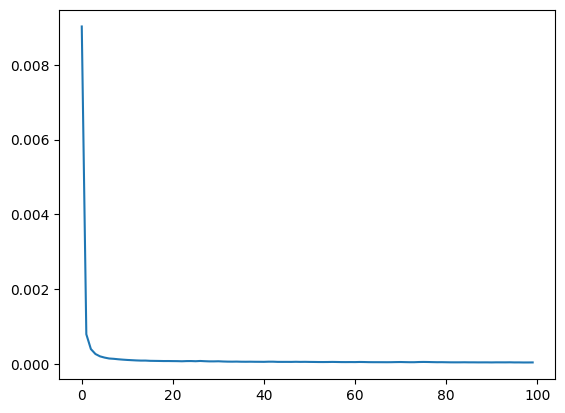

In [109]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [110]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 9ms/step


In [111]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

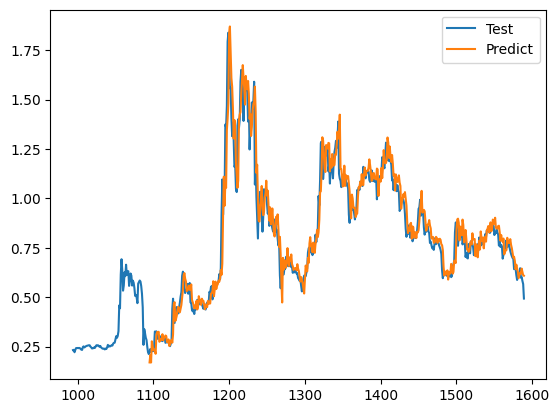

In [112]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [113]:
print(val_data1.shape)
print(y_pred_val1.shape)

(399, 1)
(298, 1)


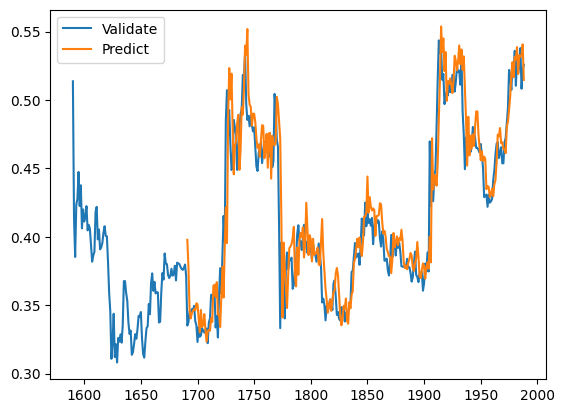

In [114]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [118]:
print('---------VALIDATE----------')

def mean_absolute_percentage_error(y_true, y_pred):
    common_length = min(len(y_true), len(y_pred))
    errors = np.abs(y_true[:common_length] - y_pred[:common_length]) / y_true[:common_length] * 100
    mape = np.mean(errors)
    return mape

valid_mape1 = mean_absolute_percentage_error(yval1,y_pred_val1)
# valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 414.1805570618271
MAE: 0.33868228050256033
RMSE: 0.3446262598940351
--------------------------
---------TEST----------
MAPE: 451.1014281654212
MAE: 0.6366671922970957
RMSE: 0.714641862633426
-------------------


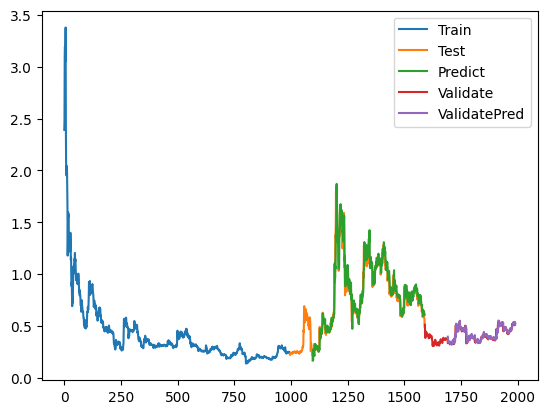

In [119]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()